## Performance Tests with Multi-Threading, Numba and Cython <br> Beta Edition
### Created by: GENG, Yu <br> 2017-12-11

### Set-up environment

In [1]:
from __future__ import print_function  # required by numba
from numba import jit, vectorize, float64

import numpy as np
import matplotlib.pyplot as plt

### Disable auto-scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Compute $\pi$ using the Chudnovsky Algorithm

In [3]:
from decimal import Decimal as Dec, getcontext as gc

def PI(maxK=70, prec=1008, disp=1007):
    # parameter defaults chosen to gain
    # 1000+ digits within a few seconds
    gc().prec = prec
    K, M, L, X, S = 6, 1, 13591409, 1, 13591409 
    for k in range(1, maxK+1):
        M = (K**3 - (K<<4)) * M / k**3 
        L += 545140134
        X *= -262537412640768000
        S += Dec(M * L) / X
        K += 12
    pi = 426880 * Dec(10005).sqrt() / S
    pi = Dec(str(pi)[:disp]) # drop few digits of precision for accuracy
    print('PI(maxK=%d iterations, gc().prec=%d, disp=%d digits) =\n%s' \
          % (maxK, prec, disp, pi))
    return pi

### Run the example

In [4]:
%time Pi = PI()  # do not use %timeit

PI(maxK=70 iterations, gc().prec=1008, disp=1007 digits) =
3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787

### Accelerate it with Numba

In [5]:
@jit  # do not use (nopython=True)
def PI_jit(maxK=70, prec=1008, disp=1007):
    # parameter defaults chosen to gain
    # 1000+ digits within a few seconds
    gc().prec = prec
    K, M, L, X, S = 6, 1, 13591409, 1, 13591409 
    for k in range(1, maxK+1):
        M = (K**3 - (K<<4)) * M / k**3 
        L += 545140134
        X *= -262537412640768000
        S += Dec(M * L) / X
        K += 12
    pi = 426880 * Dec(10005).sqrt() / S
    pi = Dec(str(pi)[:disp]) # drop few digits of precision for accuracy
    print('PI(maxK=%d iterations, gc().prec=%d, disp=%d digits) =\n%s' \
          % (maxK, prec, disp, pi))
    return pi

### Re-run the example

In [6]:
%time Pi = PI_jit()

PI(maxK=70 iterations, gc().prec=1008, disp=1007 digits) =
3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787

### Shaded & power normalized rendering

In [7]:
import numpy as np


def mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    X = np.linspace(xmin, xmax, xn, dtype=np.float32)
    Y = np.linspace(ymin, ymax, yn, dtype=np.float32)
    C = X + Y[:, None]*1j
    N = np.zeros(C.shape, dtype=int)
    Z = np.zeros(C.shape, np.complex64)
    for n in range(maxiter):
        I = np.less(abs(Z), horizon)
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N


import time
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt


def mandelbrot(filename):
    xmin, xmax, xn = -2.25, +0.75, 3000/2
    ymin, ymax, yn = -1.25, +1.25, 2500/2
    maxiter = 200
    horizon = 2.0 ** 40
    log_horizon = np.log(np.log(horizon))/np.log(2)
    Z, N = mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

    # Normalized recount as explained in:
    # https://linas.org/art-gallery/escape/smooth.html
    # https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift

    # This line will generate warnings for null values but it is faster to
    # process them afterwards using the nan_to_num
    with np.errstate(invalid='ignore'):
        M = np.nan_to_num(N + 1 -
                          np.log(np.log(abs(Z)))/np.log(2) +
                          log_horizon)

    dpi = 72
    width = 10
    height = 10*yn/xn
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, aspect=1)

    # Shaded rendering
    light = colors.LightSource(azdeg=315, altdeg=10)
    M = light.shade(M, cmap=plt.cm.PuBu, vert_exag=1.5,
                    norm=colors.PowerNorm(0.3), blend_mode='hsv')
    plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
    ax.set_xticks([])
    ax.set_yticks([])

    # Some advertisement for matplotlib
    year = time.strftime("%Y")
    major, minor, micro = matplotlib.__version__.split('.', 2)
    text = ("The Mandelbrot fractal set\n"
            "Rendered with matplotlib %s.%s, %s - http://matplotlib.org"
            % (major, minor, year))
    ax.text(xmin+.025, ymin+.025, text, color="white", fontsize=12, alpha=0.5)
    
    plt.savefig(filename)
    plt.show()  # should be saved first
    print("File saved as:", filename)

### Examine working directory

In [8]:
import os
import shutil

# Examine working directory.
outdir = './output/perform_test/'

if os.path.isdir(outdir):
    print("Cleaning previous output...")
    shutil.rmtree(outdir)
    os.mkdir(outdir)
else:
    os.mkdir(outdir)

Cleaning previous output...


### Render and save the plot

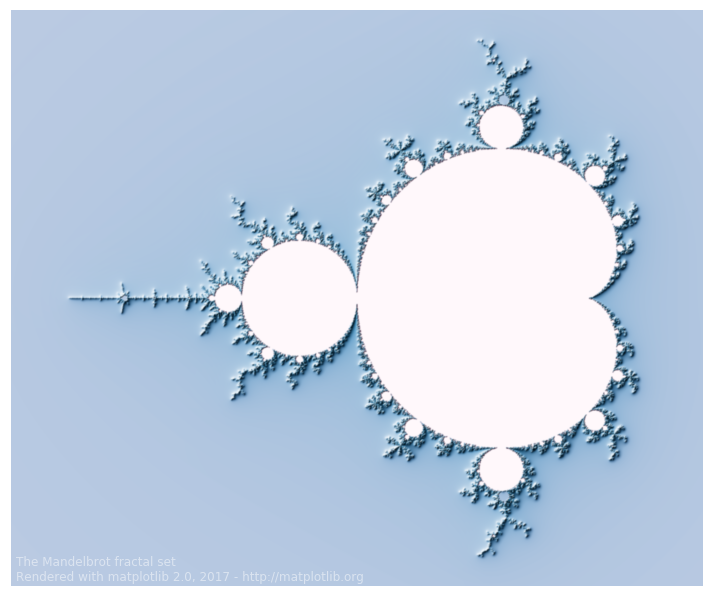

File saved as: ./output/perform_test/mandelbrot.png
CPU times: user 12.1 s, sys: 1.64 s, total: 13.8 s
Wall time: 14.7 s


In [9]:
%time mandelbrot(outdir + 'mandelbrot.png')

### Accelerate it with Numba

In [10]:
@jit
def mandelbrot_set_jit(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    X = np.linspace(xmin, xmax, xn, dtype=np.float32)
    Y = np.linspace(ymin, ymax, yn, dtype=np.float32)
    C = X + Y[:, None]*1j
    N = np.zeros(C.shape, dtype=int)
    Z = np.zeros(C.shape, np.complex64)
    for n in range(maxiter):
        I = np.less(abs(Z), horizon)
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N

# do not use @jit here
def mandelbrot_jit(filename):
    xmin, xmax, xn = -2.25, +0.75, 3000/2
    ymin, ymax, yn = -1.25, +1.25, 2500/2
    maxiter = 200
    horizon = 2.0 ** 40
    log_horizon = np.log(np.log(horizon))/np.log(2)
    Z, N = mandelbrot_set_jit(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

    # Normalized recount as explained in:
    # https://linas.org/art-gallery/escape/smooth.html
    # https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift

    # This line will generate warnings for null values but it is faster to
    # process them afterwards using the nan_to_num
    with np.errstate(invalid='ignore'):
        M = np.nan_to_num(N + 1 -
                          np.log(np.log(abs(Z)))/np.log(2) +
                          log_horizon)

    dpi = 72
    width = 10
    height = 10*yn/xn
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, aspect=1)

    # Shaded rendering
    light = colors.LightSource(azdeg=315, altdeg=10)
    M = light.shade(M, cmap=plt.cm.PuBu, vert_exag=1.5,
                    norm=colors.PowerNorm(0.3), blend_mode='hsv')
    plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
    ax.set_xticks([])
    ax.set_yticks([])

    # Some advertisement for matplotlib
    year = time.strftime("%Y")
    major, minor, micro = matplotlib.__version__.split('.', 2)
    text = ("The Mandelbrot fractal set\n"
            "Rendered with matplotlib %s.%s, %s - http://matplotlib.org"
            % (major, minor, year))
    ax.text(xmin+.025, ymin+.025, text, color="white", fontsize=12, alpha=0.5)
    
    plt.savefig(filename)
    plt.show()  # should be saved first
    print("File saved as:", filename)

### Re-render it

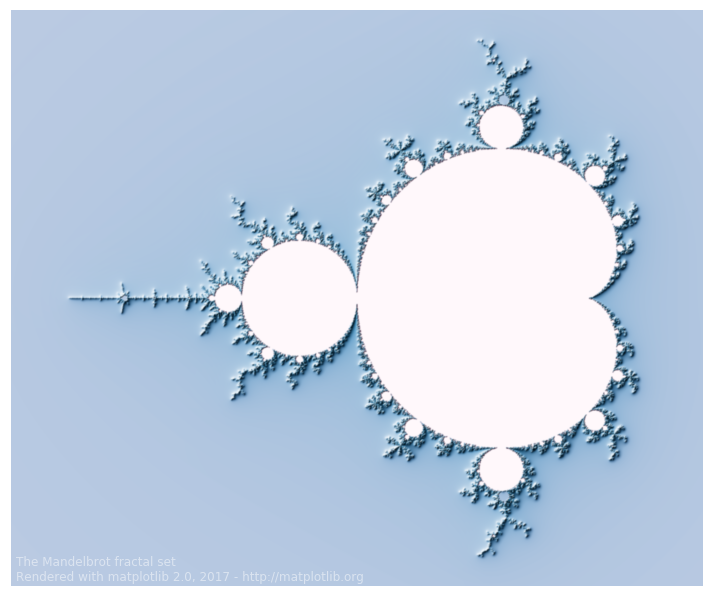

File saved as: ./output/perform_test/mandelbrot_jit.png
CPU times: user 13.9 s, sys: 2.33 s, total: 16.3 s
Wall time: 17.4 s


In [11]:
%time mandelbrot_jit(outdir + 'mandelbrot_jit.png')